<a href="https://colab.research.google.com/github/julia-walker/ML_Final_Project/blob/main/ML_Final_Project_Updated_11_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Setup


In [10]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import matplotlib as plt
import pandas as pd


# Extra imports for data pre- processing
!pip install rasterio==1.3.9
import rasterio

!pip install geopandas
import geopandas as gpd

!pip install --upgrade pyshp

!pip install --upgrade shapely

!pip install --upgrade descartes

!pip install --upgrade rtree

from __future__ import print_function

from osgeo import ogr


In [16]:
%%shell

wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh

chmod +x Miniconda3-latest-Linux-x86_64.sh

bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

conda install -q -y --prefix /usr/local gdal

--2023-11-13 09:46:24--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120771089 (115M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 115.18M  94.3MB/s    in 1.2s    

2023-11-13 09:46:26 (94.3 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [120771089/120771089]

PREFIX=/usr/local
Unpacking payload ...
                                                                                         
Installing base environment...





Preparing transaction: - \ | / - \ | / - \ | done
Executing transaction: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

Pre-processing of Training Data

In [11]:
#Code adapted from "Importing and Using Vector data-OGR library" tutorial by Chris Holden
#https://ceholden.github.io/open-geo-tutorial/python/chapter_4_vector.html

#download training polygon data from google drive
!gdown 1eU1u_FC2Y1qgH-5pCz0qQT1iwXArHXsL
!gdown 1Avi9D_HhnP-ZH_VJLEd9ckeInoAZ_X7a
!gdown 1APoauolAvB-11SavW1NMttRTSt_LqWs5
!gdown 15l9P6wHhxF89DMPSF3xX91ktp3jIlMXT


# Open the dataset from the file
dataset = ogr.Open('./polygons_SA.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not dataset:
    print('Error: could not open dataset')



Downloading...
From: https://drive.google.com/uc?id=1eU1u_FC2Y1qgH-5pCz0qQT1iwXArHXsL
To: /content/polygons_SA.shp
100% 8.42k/8.42k [00:00<00:00, 19.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Avi9D_HhnP-ZH_VJLEd9ckeInoAZ_X7a
To: /content/polygons_SA.prj
100% 400/400 [00:00<00:00, 1.47MB/s]
Downloading...
From: https://drive.google.com/uc?id=1APoauolAvB-11SavW1NMttRTSt_LqWs5
To: /content/polygons_SA.dbf
100% 721/721 [00:00<00:00, 2.45MB/s]
Downloading...
From: https://drive.google.com/uc?id=15l9P6wHhxF89DMPSF3xX91ktp3jIlMXT
To: /content/polygons_SA.shx
100% 140/140 [00:00<00:00, 452kB/s]


In [12]:
#download Vallon de Nant study area image from google drive
!gdown 12KHX15jBRWnlgQG9orqhCb_J-fWLWXde

Downloading...
From: https://drive.google.com/uc?id=12KHX15jBRWnlgQG9orqhCb_J-fWLWXde
To: /content/SA_Raster.tif
100% 25.2M/25.2M [00:00<00:00, 153MB/s] 


In [14]:
!compgen-c | grep gdal

/bin/bash: line 1: compgen-c: command not found


In [17]:

#Code adapted from "Importing and Using Vector data-OGR library" tutorial by Chris Holden
#https://ceholden.github.io/open-geo-tutorial/python/chapter_4_vector.html

#converting training polygons into raster with the same extent as study area raster
%%bash

# Explanation of switches:
# -a ==> write values from the"id" attribute of the shapefile
# -layer ==> the layer name of our shapefile
# -of ==> Output raster file format
# -a_srs ==> output spatial reference system string
# -a_nodata ==> NODATA value for output raster
# -te ==> target extent which matches the raster we want to create the ROI image for
# -tr ==> target resolution, 3 x 3m
# -ot Byte ==> Since we only have values 0 - 5, a Byte datatype is enough

gdal_rasterize -a "id" \
    -l polygons_SA \
    -of "GTiff" \
    -a_srs "+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs" \
    -a_nodata 5 \
    -te 351066 5117925 355542 5123967 \
    -tr 3 3 \
    -ot Byte \
    ./polygons_SA.shp ./training_data.gtif


0...10...20...30...40...50...60...70...80...90...100 - done.


ERROR 1: PROJ: proj_identify: Open of /usr/local/share/proj failed


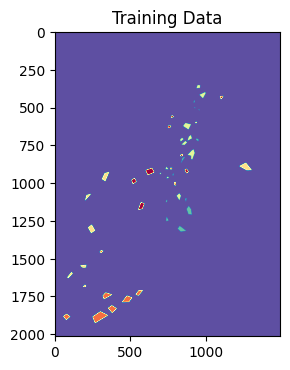

In [18]:

#Code adapted from "classification of land cover" tutorial by Chris Holden
#https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

#Generating training dataset
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('./SA_Raster.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('./training_data.gtif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display training data raster
plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Data')

plt.show()


In [19]:
#Code adapted from "classification of land cover" tutorial by Chris Holden
#https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

#Pairing X (spectral bands) with Y(land cover class labels) for training data

# How many training data samples?
n_samples = (roi < 5).sum()
print('We have {n} samples'.format(n=n_samples))


# What are our classification labels?
labels = np.unique(roi[roi < 5])
print('The training data include {n} classes: {classes}'.format(n=labels.size,
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#

X = img[roi < 5, :]
y = roi[roi < 5]


print('X matrix is sized: {sz}'.format(sz=X.shape))
print('y array is sized: {sz}'.format(sz=y.shape))

We have 30362 samples
The training data include 5 classes: [0 1 2 3 4]
X matrix is sized: (30362, 4)
y array is sized: (30362,)


Implementing Machine Learning Algorithms with Default Hyperparameters


In [20]:
#code for this section adopted from Tom Beucler's Machine Learning for Earth and Environmnetal Science Course
#https://github.com/tbeucler/2022_ML_EES/tree/main/Labs

#Split training data into training and test sets

from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [21]:
#fit training data to random forest algorithm

from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 100 trees (default)
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

Accuracy: 0.9700362199539019


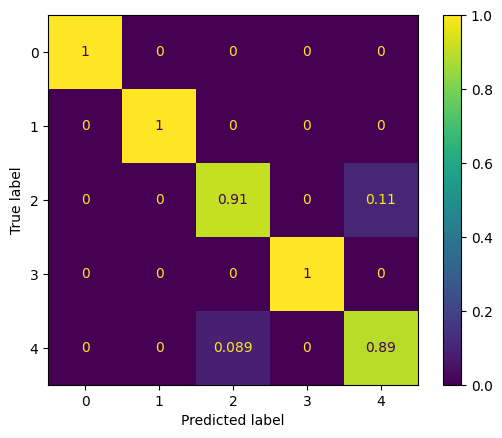

In [22]:
#test random forest algorithm on test set and compute accuracy scores and confusion matrx
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
###
y_pred = rf.predict(X_test) #prediction on the test set
accuracy = accuracy_score(y_test, y_pred) #accuracy of the prediction

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='pred') # Get a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm) # Use ConfusionMatrixDisplay to visualize matrix
disp.plot()





In [23]:
#test random forest algorithm on validation set and compute accuracy scores
y_pred2 = rf.predict(x_val) #prediction on the test set
accuracy = accuracy_score(y_val, y_pred2) #accuracy of the prediction

print("Accuracy:",metrics.accuracy_score(y_val, y_pred2))

Accuracy: 0.9677206851119895


In [ ]:
#fit training data to SVM algorithm

from sklearn import svm
sv = svm.SVC()
sv.fit(X_train, y_train) #fit to training data
y_pred_svm = sv.predict(X_test) #predict on test data

In [ ]:
# Accuracy score and confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

accuracy_svm = accuracy_score(y_test, y_pred_svm) #accuracy of the prediction

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm, normalize='pred') # Get a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm) # Use ConfusionMatrixDisplay to visualize matrix
disp.plot()

In [ ]:
#repeat prediction and accuracy for validation set
y_pred3 = sv.predict(x_val) #prediction on the test set
accuracy = accuracy_score(y_val, y_pred3) #accuracy of the prediction

print("Accuracy:",metrics.accuracy_score(y_val, y_pred3))

Implementing Machine Learning Algorithms with Best Hyperparameters after Hyperparameter GridSearch

In [ ]:
#Hyperparameter search for Random Forest
#source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import GridSearchCV
###
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = [2, 3, 4]
# Creation of the parameter grid based on the results of random search
param_grid = {'n_estimators': n_estimators, 'max_features': max_features}
# Random grid search for best hyperparameters: random search
gsrf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1) #searches grid for best parameters
gsrf.fit(X_train, y_train) # Fit the grid search to the data

In [ ]:
#return best number of trees (n_estimators) and maximum features to use
best_grid = gsrf.best_params_
best_grid


In [ ]:
#prediction based on best parameters for validation and test set
y_pred_test = gsrf.predict(X_test)
y_pred_val = gsrf.predict(x_val)
# Calculate the accuracy of the best model over the training and test sets
from sklearn.metrics import accuracy_score
print(f'Accuracy over test set: {(accuracy_score(y_test,y_pred_test)):.2%}'
f'Accuracy over validation set: {(accuracy_score(y_val,y_pred_val)):.2%}')

In [ ]:
#Source: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
from sklearn.model_selection import GridSearchCV
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) #searches parameters for best fit

# fitting the model for grid search
grid.fit(X_train, y_train)


In [ ]:
print(grid.best_params_)

In [ ]:
y_pred_train2 = grid.predict(X_train)
y_pred_test2 = grid.predict(X_test)
y_pred_val2 = grid.predict(x_val)
# Calculate the accuracy of the best model over the training and test sets
from sklearn.metrics import accuracy_score
print(f'Accuracy over test set: {(accuracy_score(y_test,y_pred_test)):.2%}'
f'Accuracy over validation set: {(accuracy_score(y_val,y_pred_val)):.2%}')


In [24]:
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :4].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

class_prediction = rf.predict(img_as_array)

class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (2014, 1492, 4) to (3004888, 4)


In [25]:
vals, counts = np.unique(class_prediction, return_counts=True)
[print(f'{val:.2%}') for val in counts/counts.sum()];

6.96%
5.29%
11.97%
65.97%
9.81%


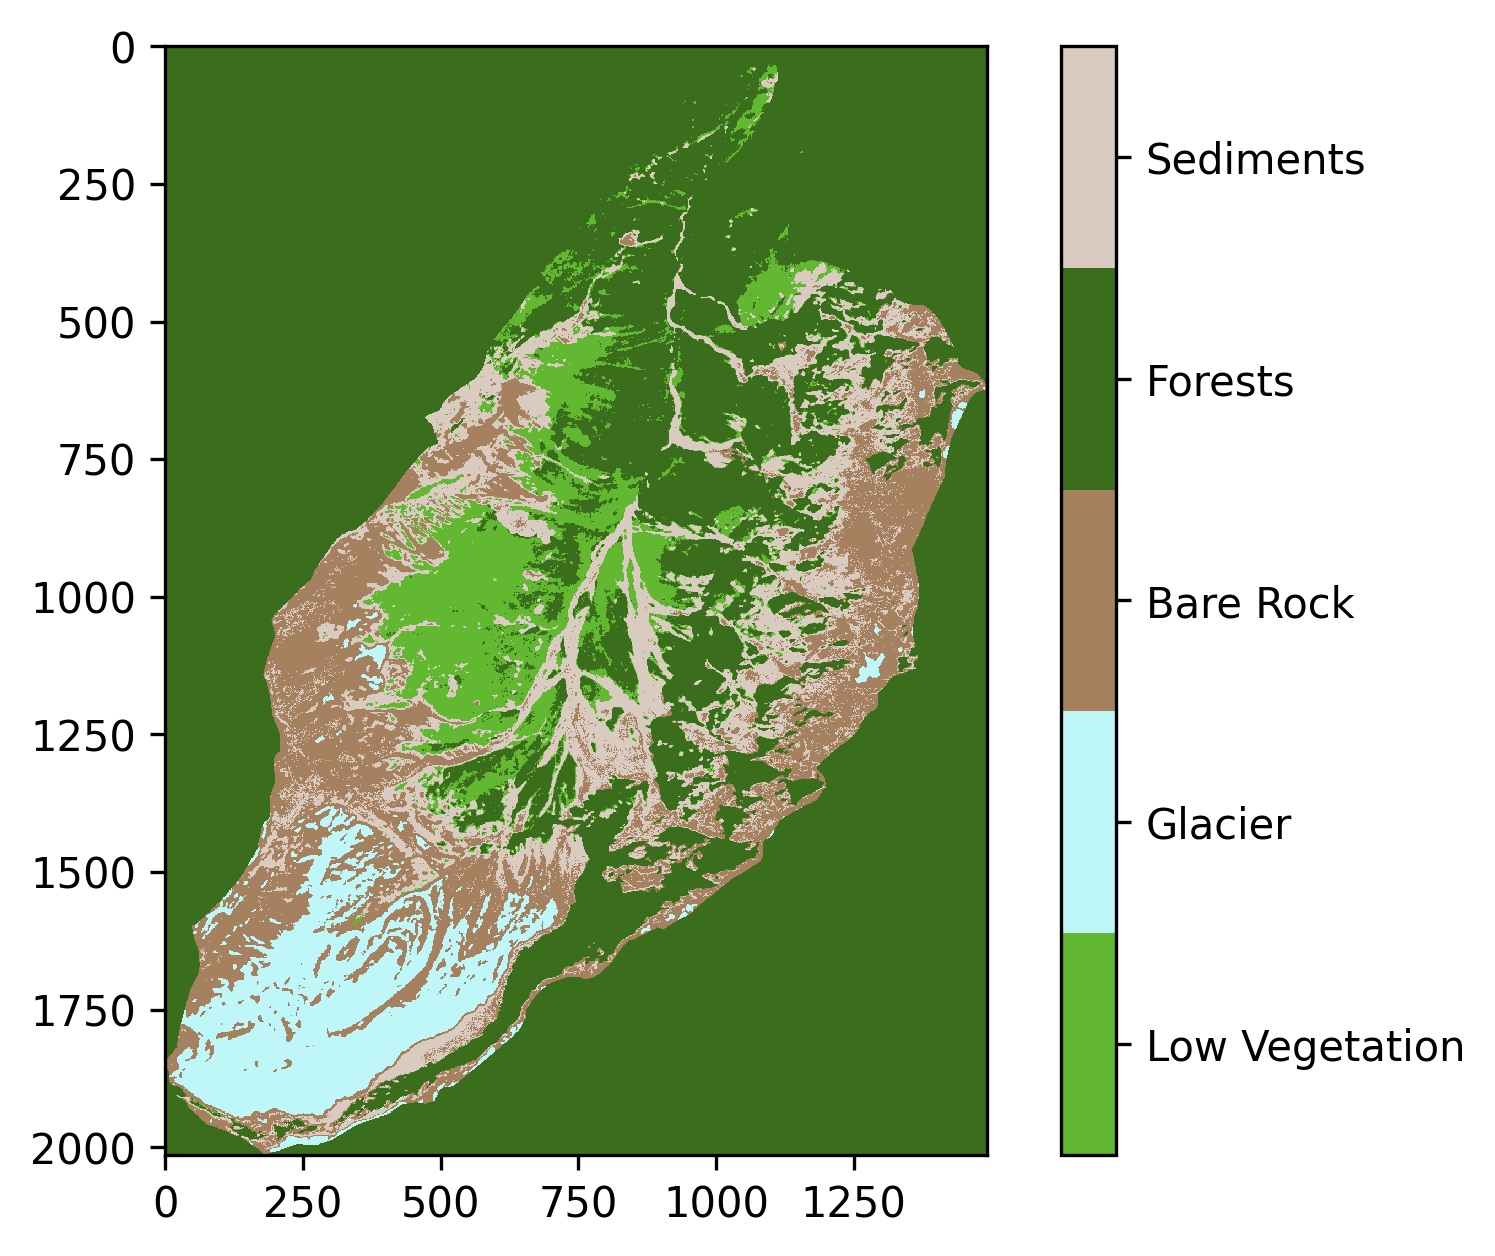

In [26]:
# Import the colors library from matplotlib
import matplotlib.colors as colors

# Generate a list of colors to be used in the 2D map
cmap = colors.ListedColormap(['#62B931',  # Low Vegetation, Class 0
                              '#BFF6F7',  # Glacier, Class 1
                              '#A68160',  # Bare Rock, Class 2
                              '#3A6D1C',  # Forests, Class 3
                              '#D9CBBF',  # Sediments, Class 4
                              ])

# Set the boundaries for each color
bounds = [-.5, 0.5,1.5,2.5,3.5,4.5]

# Calculate the boundary norm
norm = colors.BoundaryNorm(bounds,
                           cmap.N,
                           #clip=True,
                           )

# create fig and ax object
fig, ax = plt.subplots(dpi=300)

# Create the output map
out_map = ax.imshow(class_prediction, cmap=cmap, interpolation='none')

# Create the colorbar
cbar = fig.colorbar(out_map,
                    ax=ax,
                    norm=norm,
                    boundaries = bounds,
                    ticks = np.arange(0,5,1),
                    spacing='proportional'
                    )

# Set labels to human readable values
cbar.set_ticklabels(['Low Vegetation', # Class 0
                         'Glacier', # Class 1
                         'Bare Rock', # Class 2
                         'Forests', # Class 3
                         'Sediments',]) # Class 4
plt.show()



In [27]:

# Save the image in memory in PNG format
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import io



png1 = io.BytesIO()
fig.savefig(png1, format="png")

# Load this image into PIL
png2 = Image.open(png1)

# Save as TIFF
png2.save("LC_VDN.tiff")
png1.close()




In [28]:
print(class_prediction)

[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
